# Movement of actors

<div class="admonition note">
    <p class="admonition-title">In progress</p>
    <p>This document is a work in progress if you see any errors, or exclusions or have any problems, please <a href="https://github.com/absespy/ABSESpy/issues">get in touch with us</a>.</p>
</div>

In [1]:
from abses import Actor, MainModel

# create a testing model
model = MainModel(name="actor_example", base="tests")
layer = model.nature.create_module(how="from_resolution", shape=(3, 3))
actor = model.agents.new(Actor, singleton=True)

[2024-03-12 21:29:43][human          ] | Initializing a new Human Module...
[2024-03-12 21:29:43][nature         ] | Initializing a new Base Nature module...
[2024-03-12 21:29:43][nature         ] | Initializing a new Model Layer...
[2024-03-12 21:29:43][nature         ] | Using rioxarray version: 0.13.4
[2024-03-12 21:29:43][container      ] | Created 1 actors of breed Actor


In [2]:
# however, we can let it settle down on a specific position of the earth.
pos = (1, 1)
settled = actor.move.to(pos=pos, layer=layer)

actor.pos  # position of the actor now: (4, 4)
actor.on_earth  # True

True

Let's see where the actor is located at...

`layer.apply` is a useful method when you want to apply a function to all the cells in a layer. As all the cells have a method `agents.has()` to show how many agents are in the cell, we can use this method to count the number of agents in the layer.

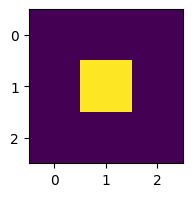

In [3]:
import matplotlib.pyplot as plt


def show_position():
    _, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(layer.apply(lambda c: c.agents.has()))
    plt.show()


show_position()

Now, we can move the actor to a new location.

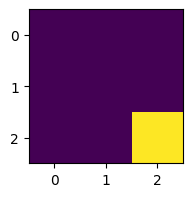

In [4]:
actor.move.by("down right", distance=1)

fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(layer.apply(lambda c: c.agents.has()))
plt.show()

Good movement!

Now, let's move the actor to a new location randomly, with a keyword arg `radius=2`.

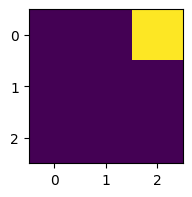

In [5]:
actor.move.random(radius=2)

fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(layer.apply(lambda c: c.agents.has()))
plt.show()

As you see! The single agent can be moved very easily to a new location.